In [ ]:
! pip install -q tensorflow numpy pandas scikit-learn mlxtend dataprep transformers
! cp drive/My\ Drive/Colab\ Notebooks/*.csv ./
! cp drive/My\ Drive/Colab\ Notebooks/*.pkl ./

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 778kB 15.7MB/s 
     |████████████████████████████████| 798kB 35.0MB/s 
     |████████████████████████████████| 8.6MB 34kB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 5.5MB 46.9MB/s 
     |████████████████████████████████| 512kB 44.7MB/s 
     |████████████████████████████████| 368kB 45.6MB/s 
     |████████████████████████████████| 1.4MB 38.6MB/s 
     |████████████████████████████████| 2.2MB 43.5MB/s 
     |████████████████████████████████| 890kB 31.7MB/s 
     |████████████████████████████████| 1.1MB 46.1MB/s 
     |████████████████████████████████| 3.0MB 44.8MB/s 
     |████████████████████████████████| 655kB 50.3MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
ERROR: panel 0.9.7 has requirement bokeh>=2.1, but you'll 

In [ ]:
def augment(training):
  training = np.repeat(training, 10, axis=0)
  for i in range(0, len(training), 10):
    print(i)
    for j in range(len(X)):
        if (training[i][:1000] == X[j][:1000]).all():
          for k in range(1, 10):
            training[i+k] = np.concatenate([X[i+k][:1000], training[i+k][1000:]])
          break
  return training

In [ ]:
def ds_from_df(df, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Meme')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
def create_map():
  temp = df[['Visual']].values
  counter = 0
  map = {}
  for i in temp:
    for j in i[0].split():
      if j.strip(',') not in map and j.strip(',') != '0':
        map[j.strip(',')] = counter
        counter += 1
  return map

In [ ]:
def get_X(temp):
  res = []
  for i in range(0, len(temp), 10):
    res.append(temp[i])
  return np.array(res)

In [ ]:
def ohe(map):
  one_hot_encode = []
  temp = df[['Visual']].values

  for i in temp:
    arr = list(np.zeros(len(map),dtype=int))
    for j in i[0].split():
      if j.strip(',') != '0':
        arr[map[j.strip(',')]] = 1
    one_hot_encode.append(arr)
  return np.array(one_hot_encode)

In [ ]:
import pandas as pd

df = pd.read_csv('dankmemes_task1_train.csv')
embedding = pd.read_csv('dankmemes_task1_train_embeddings.csv', header=None)

In [ ]:
import numpy as np
import pickle

X, y = get_X(pickle.load(open('resnest_embeddings.pkl', 'rb'))), df[['Meme']].values
# X, y = np.array([embedding[1][i].split() for i in range(1600)]).astype(float), df[['Meme']].values

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

ssc = StandardScaler()
mms = MinMaxScaler()

In [ ]:
import pickle
from datetime import date

temp = mms.fit_transform(np.array([(date(int(i[0].split('-')[0]), int(i[0].split('-')[1]), int(i[0].split('-')[2])) - date(2015, 1, 1)).days for i in df[['Date']].values.tolist()]).reshape(1600, 1))
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

temp = ssc.fit_transform(df[['Engagement']].values)
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

temp = ohe(create_map())
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

temp = pickle.load(open('bert_embeddings.pkl', 'rb'))
print(temp.shape)
X = np.hstack((X, temp))
print(X.shape)

(1600, 1)
(1600, 1001)
(1600, 1)
(1600, 1002)
(1600, 71)
(1600, 1073)
(1600, 768)
(1600, 1841)


In [ ]:
def build_model(input_shape=(None, 1841)):
  model = tf.keras.Sequential([tf.keras.layers.Dense(1841, 
                                                     name='dense_1',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dense(2048, 
                                                     name='dense_2',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dropout(rate=0.5),
                               tf.keras.layers.Dense(1024, 
                                                     name='dense_3',
                                                     activation=tf.keras.activations.relu),
                               tf.keras.layers.Dense(1, name='output',
                                                     activation=tf.keras.activations.sigmoid)])
  print(model.compute_output_shape(input_shape=input_shape))
  model.build(input_shape=input_shape)
  return model

In [ ]:
buffer_size = 10000
batch_size = 64
num_epochs = 100

In [21]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train = augment(X_train)
y_train = np.repeat(y_train, 10, axis=0)

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train = ds_train.shuffle(buffer_size=buffer_size,
                            reshuffle_each_iteration=False)
ds_test = ds_test.batch(batch_size)
ds_train = ds_train.batch(batch_size)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600


IndexError: ignored

In [ ]:
print(X.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1600, 1000) (1280, 1000) (1280, 1) (320, 1000) (320, 1)


In [ ]:
model = build_model(input_shape=(None, 1000))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

(None, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1841)              3391122   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              3772416   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
output (Dense)               (None, 1)                 1025      
Total params: 9,262,739
Trainable params: 9,262,739
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(ds_train,
                 validation_data=ds_test,
                 epochs=num_epochs,
                 batch_size=batch_size)

Epoch 1/100
400/400 [==============================] - 31s 77ms/step - loss: 0.6230 - binary_accuracy: 0.6363 - val_loss: 0.6631 - val_binary_accuracy: 0.6156
Epoch 2/100
400/400 [==============================] - 31s 78ms/step - loss: 0.4660 - binary_accuracy: 0.7794 - val_loss: 0.8238 - val_binary_accuracy: 0.6313
Epoch 3/100
400/400 [==============================] - 31s 78ms/step - loss: 0.3707 - binary_accuracy: 0.8289 - val_loss: 0.9209 - val_binary_accuracy: 0.6469
Epoch 4/100
400/400 [==============================] - 31s 78ms/step - loss: 0.2808 - binary_accuracy: 0.8749 - val_loss: 1.2952 - val_binary_accuracy: 0.6438
Epoch 5/100
400/400 [==============================] - 31s 78ms/step - loss: 0.2295 - binary_accuracy: 0.9008 - val_loss: 1.2705 - val_binary_accuracy: 0.6313
Epoch 6/100
400/400 [==============================] - 31s 79ms/step - loss: 0.1856 - binary_accuracy: 0.9191 - val_loss: 1.7000 - val_binary_accuracy: 0.6438
Epoch 7/100
400/400 [=========================

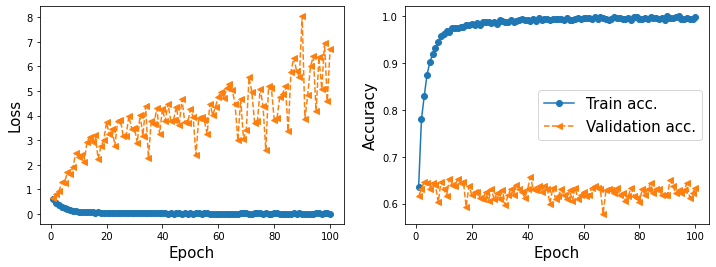

In [ ]:
import matplotlib.pyplot as plt

history = hist.history
x_arr = np.arange(len(history['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history['loss'], '-o', label='Train loss')
ax.plot(x_arr, history['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, history['binary_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, history['val_binary_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
model.save('models/augmented_feedforward')
! cp -r models ./drive/My\ Drive/Colab\ Notebooks/

INFO:tensorflow:Assets written to: models/augmented_feedforward/assets
